# 🌱 Notebook 1/4 - Climate & Environment (EDA + Feature Readiness)

## Problem Statement
Air pollution poses significant health, economic, and environmental risks.
Understanding **temporal trends**, **seasonal behavior**, and **geographic hotspots**
is essential for effective environmental regulation and urban planning.

This notebook analyzes air quality measurements across India to uncover patterns in pollution levels over time and space.
This notebook focuses on **data validation, exploratory analysis, and feature readiness**.
Downstream causal analysis and health impact modeling are handled in Notebook 2.

## Policy & Planning Relevance
- Identifying pollution hotspots supports targeted mitigation
- Seasonal patterns inform emergency response and advisories
- Trend analysis helps evaluate policy effectiveness

## Target Variables
- Pollutant concentrations: PM2.5, PM10, NO₂, SO₂, O₃
- Time: timestamp, month, year (derived later)
- Location: monitoring-station level (city when available)

## Scope & Limitations
- Geography: India only
- Data source: OpenAQ (official + community monitors)
- Values represent concentrations, **not AQI**
- Results reflect monitoring availability and reporting bias


## 🟦 Phase 1: Ingestion & Validation

Goal:
- Load raw OpenAQ dataset and create a validated India-only snapshot
- Validate schema, dtypes, and missing values
- Ensure project path & environment are correct


In [1]:
from utils.path_setup import setup_project_path
from ingestion.data_factory import load_data
import os

PROJECT_ROOT = setup_project_path()
os.chdir(PROJECT_ROOT)
print("Project root:", PROJECT_ROOT)


Project root: d:\def_main\Code\MyProjects\eda-mlops-portfolio


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from src.preprocessing.clean_openaq import clean_openaq
from src.utils.logger import get_logger


## Data Loading

Raw air quality data is loaded from the OpenAQ dataset.
At this stage, the data contains measurements from multiple countries
and may include inconsistent formats or missing fields.


In [3]:
df_raw = load_data("raw/climate", "openaq_raw.csv")
print("Raw shape:", df_raw.shape)
df_raw.head()

Raw shape: (61177, 10)


,Country Code,City,Location,Coordinates,Pollutant,Source Name,Unit,Value,Last Updated,Country Label
0,CN,NaN,市八十六中,"23.1047, 113.43319999999999",O3,ChinaAQIData,µg/m³,36.0,2021-08-09T16:30:00+05:30,China
1,CN,NaN,市农科院,"21.9508, 108.6553",SO2,ChinaAQIData,µg/m³,7.0,2020-12-31T21:30:00+05:30,China
2,CN,NaN,市发改委,"29.8454, 114.3107",PM2.5,ChinaAQIData,µg/m³,26.0,2021-08-09T16:30:00+05:30,China
3,CN,NaN,市委,"30.457600000000003, 106.63030000000002",O3,ChinaAQIData,µg/m³,91.0,2021-08-09T16:30:00+05:30,China
4,CN,NaN,市委党校,"27.731400000000004, 112.0194",NO2,ChinaAQIData,µg/m³,19.0,2021-08-09T16:30:00+05:30,China


## Feature Overview

The dataset includes location metadata, pollutant type,
measurement value, timestamp, and source information.


In [4]:
print(df_raw.columns.tolist())


['Country Code', 'City', 'Location', 'Coordinates', 'Pollutant', 'Source Name', 'Unit', 'Value', 'Last Updated', 'Country Label']


## Data Cleaning & Preprocessing

This step:
- Filters data to **India only**
- Ensures numeric pollutant values
- Standardizes column formats
- Prepares the dataset for EDA

This step is critical to avoid invalid comparisons and geographic leakage.


In [5]:
# Apply cleaning (India-only, type fixes, datetime parsing)
df = clean_openaq(df_raw)

# Sanity Check
print("Rows after cleaning (India-only):", len(df))


Rows after cleaning (India-only): 2454


## Persist Cleaned Snapshot (Reusable)

The cleaned, India-only dataset is saved for reuse in later analysis
and downstream notebooks.


In [6]:
# Persist validated snapshot (NOT final processed data)
processed_dir = PROJECT_ROOT / "datasets" / "processed" / "climate"
processed_dir.mkdir(parents=True, exist_ok=True)

output_path = processed_dir / "openaq_processed.csv"
df.to_csv(output_path, index=False)

logger = get_logger("climate_eda")
logger.info("Phase 1 snapshot saved to %s", output_path)

print(f"✅ Phase 1 snapshot saved to: {output_path}")
print("Snapshot row count:", len(df))


2026-01-17 23:29:29,435 | INFO | climate_eda | Phase 1 snapshot saved to d:\def_main\Code\MyProjects\eda-mlops-portfolio\datasets\processed\climate\openaq_processed.csv


✅ Phase 1 snapshot saved to: d:\def_main\Code\MyProjects\eda-mlops-portfolio\datasets\processed\climate\openaq_processed.csv
Snapshot row count: 2454


## Post-cleaning Sanity Check

A quick inspection of the cleaned dataset confirms
column types, missing values, and dataset size.


In [7]:
df.isna().sum().sort_values(ascending=False)


City             2448
Country Code        0
Location            0
Coordinates         0
Pollutant           0
Source Name         0
Unit                0
Value               0
Last Updated        0
Country Label       0
dtype: int64

### Why validate early?

Early schema validation prevents silent downstream errors in temporal aggregation,
geospatial joins, and ML pipelines.


## 🟦 Phase 2: Data Profiling (Post-Cleaning Snapshot)

Objective:
- Understand dataset size and coverage
- Quantify monitoring bias and missingness
- Validate readiness for downstream analysis



In [8]:
print("Current columns:", df.columns.tolist())


Current columns: ['Country Code', 'City', 'Location', 'Coordinates', 'Pollutant', 'Source Name', 'Unit', 'Value', 'Last Updated', 'Country Label']


In [9]:
# Basic profiling
profile = {
    "rows": len(df),
    "pollutants": df["Pollutant"].nunique(),
    "locations": df["Location"].nunique(),
    "missing_city_pct": df["City"].isna().mean() * 100 if "City" in df.columns else None,
    "units": df["Unit"].value_counts().to_dict()
}

pd.Series(profile)


rows                                                             2454
pollutants                                                         10
locations                                                         394
missing_city_pct                                            99.755501
units               {'µg/m³': 2449, 'ppm': 2, '%': 1, 'particles/c...
dtype: object

## 🟦 Phase 3: Data Cleaning & Feature Readiness

Objective:
- Clean and standardize raw columns
- Handle missing and inconsistent data
- Convert data into analysis-ready formats
- Prepare features for downstream analysis / modeling

Outcome:
- A clean, consistent DataFrame
- Clearly defined usable vs unusable columns


### 3.1 Dataset Snapshot

Re-checking shape, columns, and data types before cleaning.


In [10]:
df.shape, df.columns, df.dtypes


((2454, 10),
 Index(['Country Code', 'City', 'Location', 'Coordinates', 'Pollutant',
        'Source Name', 'Unit', 'Value', 'Last Updated', 'Country Label'],
       dtype='object'),
 Country Code      object
 City              object
 Location          object
 Coordinates       object
 Pollutant         object
 Source Name       object
 Unit              object
 Value            float64
 Last Updated      object
 Country Label     object
 dtype: object)

### 3.2 Missing Value Analysis

Observations:
- `City` is almost entirely missing
- Other columns are fully populated
- Decision needed: drop, infer, or retain as-is


In [11]:
df.isna().sum().sort_values(ascending=False)


City             2448
Country Code        0
Location            0
Coordinates         0
Pollutant           0
Source Name         0
Unit                0
Value               0
Last Updated        0
Country Label       0
dtype: int64

Decision:
- `City` column has negligible usable data → drop
- All other columns retained


In [12]:
df = df.drop(columns=["City"])


In [13]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)
df.columns


Index(['country_code', 'location', 'coordinates', 'pollutant', 'source_name',
       'unit', 'value', 'last_updated', 'country_label'],
      dtype='object')

### 3.4 Date-Time Conversion

Converting `last_updated` to pandas datetime for:
- Temporal analysis
- Sorting
- Time-based aggregation


In [14]:
df["last_updated"] = pd.to_datetime(df["last_updated"], errors="coerce")
df["last_updated"].dtype


datetime64[ns, UTC+05:30]

### 3.5 Coordinate Processing

Problem:
- `coordinates` stored as string: `"lat, lon"`

Solution:
- Split into numeric `latitude` and `longitude`


In [15]:
coords = df["coordinates"].str.split(",", expand=True)

df["latitude"] = coords[0].astype(float)
df["longitude"] = coords[1].astype(float)

df = df.drop(columns=["coordinates"])

df[["latitude", "longitude"]].head()


,latitude,longitude
939,17.429398,78.569354
940,17.585705,78.126199
941,11.406829,76.713897
942,9.363990,78.831977
943,11.032800,77.034900


### 3.6 Categorical Data Normalization

Standardizing text fields:
- Remove casing inconsistencies
- Strip whitespace
- Improve grouping reliability


In [16]:
cat_cols = ["location", "pollutant", "source_name", "unit", "country_label"]

for col in cat_cols:
    df[col] = df[col].str.strip().str.lower()

df[cat_cols].head()


,location,pollutant,source_name,unit,country_label
939,"nacharam_tsiic iala, hyderabad - tspcb",pm2.5,caaqm,µg/m³,india
940,"iith kandi, hyderabad - tspcb",pm2.5,caaqm,µg/m³,india
941,"bombay castel, ooty - tnpcb",no2,caaqm,µg/m³,india
942,"chalai bazaar, ramanathapuram - tnpcb",o3,caaqm,µg/m³,india
943,"psg college of arts and science, coimbatore - ...",so2,caaqm,µg/m³,india


### 3.7 Numeric Value Validation

Ensuring:
- No negative pollutant values
- No obvious corrupt readings


Decision:
- Negative and zero values are invalid → remove
- Very small positive values retained to avoid truncation bias


In [17]:
df = df[df["value"].between(0.01, 1e5)]
df["value"].describe()

count     2365.000000
mean       321.576357
std       1968.058312
min          0.010000
25%         12.400000
50%         40.560000
75%        175.180000
max      80000.000000
Name: value, dtype: float64

### 3.8 Duplicate Record Check

Duplicates defined by:
- Same location
- Same pollutant
- Same timestamp


In [18]:
df.duplicated(
    subset=["location", "pollutant", "last_updated"]
).sum()


np.int64(0)

In [19]:
df = df.drop_duplicates(
    subset=["location", "pollutant", "last_updated"]
)


### 3.9 Inspect & Remove Rare Pollutants

#### Step 1: Inspect pollutant frequencies
- Check how many measurements exist per pollutant
- Identify pollutants with very few observations


In [20]:
# Count observations per pollutant
pollutant_counts = df['pollutant'].value_counts()

# Display full frequency table
print("Pollutant observation counts:")
print(pollutant_counts)


Pollutant observation counts:
pollutant
pm2.5               410
no2                 403
co                  398
pm10                386
so2                 385
o3                  379
pm1                   1
relativehumidity      1
um003                 1
temperature           1
Name: count, dtype: int64


#### Step 2: Remove pollutants with very few observations
- Minimum threshold: 10 observations
- Ensures robust statistics and meaningful downstream analysis


In [21]:
MIN_OBSERVATIONS = 10

# Keep only pollutants with >= MIN_OBSERVATIONS
pollutants_to_keep = pollutant_counts[pollutant_counts >= MIN_OBSERVATIONS].index.tolist()
df = df[df['pollutant'].isin(pollutants_to_keep)]

# Log info
logger.info(f"Pollutants removed (less than {MIN_OBSERVATIONS} observations): "
            f"{set(pollutant_counts.index) - set(pollutants_to_keep)}")
logger.info(f"Remaining pollutants: {pollutants_to_keep}")

# Quick check
print("\nPollutants retained:")
print(df['pollutant'].value_counts())


2026-01-17 23:29:30,390 | INFO | climate_eda | Pollutants removed (less than 10 observations): {'um003', 'relativehumidity', 'temperature', 'pm1'}
2026-01-17 23:29:30,392 | INFO | climate_eda | Remaining pollutants: ['pm2.5', 'no2', 'co', 'pm10', 'so2', 'o3']



Pollutants retained:
pollutant
pm2.5    410
no2      403
co       398
pm10     386
so2      385
o3       379
Name: count, dtype: int64


#### Notes
- Rare pollutants (less than 10 measurements) are removed
- Prevents skewed statistics in later phases
- Ensures analysis focuses on pollutants with meaningful data


### 3.10 Outlier Detection & Treatment

Air quality datasets often contain extreme values due to sensor errors,
unit inconsistencies, or reporting anomalies. To ensure analytical validity,
a two-stage outlier handling strategy was applied:

1. **Physical plausibility limits**
   - PM2.5 values above 500 µg/m³
   - PM10 values above 1000 µg/m³
   These values exceed realistic atmospheric concentrations and are treated
   as invalid measurements.

2. **Statistical trimming for gaseous pollutants**
   - NO₂, SO₂, and O₃ values above the 99th percentile were removed
   to reduce the influence of extreme but rare spikes.

This approach balances scientific realism with statistical robustness,
ensuring the dataset remains representative while eliminating spurious extremes.



In [22]:
print("Phase 3 — Outlier Handling")
print("Total rows before outlier removal:", len(df))

# -------------------------------
# 1️⃣ Define defensible thresholds
# -------------------------------

PHYSICAL_LIMITS = {
    "PM2.5": 500,   # µg/m³ (already extreme; beyond this is invalid)
    "PM10": 1000    # µg/m³
}

PERCENTILE_BASED = ["NO2", "SO2", "O3"]

rows_before = len(df)

# -------------------------------
# 2️⃣ Apply physical limits first
# -------------------------------

for pol, limit in PHYSICAL_LIMITS.items():
    if pol.lower() in df["pollutant"].str.lower().unique():
        before = len(df)
        df = df[
            ~(
                (df["pollutant"].str.lower() == pol.lower()) &
                (df["value"] > limit)
            )
        ]
        removed = before - len(df)
        print(f"{pol}: removed {removed} rows above {limit} µg/m³")

# ----------------------------------
# 3️⃣ Apply percentile-based trimming
# ----------------------------------

for pol in PERCENTILE_BASED:
    mask = df["pollutant"].str.lower() == pol.lower()
    if mask.any():
        threshold = df.loc[mask, "value"].quantile(0.99)
        before = len(df)
        df = df[~(mask & (df["value"] > threshold))]
        removed = before - len(df)
        print(f"{pol}: removed {removed} rows above 99th percentile ({threshold:.2f})")

# -------------------------------
# 4️⃣ Final sanity checks
# -------------------------------

print("Total rows after outlier removal:", len(df))
print(
    "Max PM2.5 after cleaning:",
    df[df["pollutant"].str.lower() == "pm2.5"]["value"].max()
)


Phase 3 — Outlier Handling
Total rows before outlier removal: 2361
PM2.5: removed 3 rows above 500 µg/m³
PM10: removed 2 rows above 1000 µg/m³
NO2: removed 5 rows above 99th percentile (169.25)
SO2: removed 4 rows above 99th percentile (98.08)
O3: removed 4 rows above 99th percentile (214.04)
Total rows after outlier removal: 2343
Max PM2.5 after cleaning: 472.46


**Notes:**

- PM2.5 and PM10 are constrained using physical plausibility limits rather than percentile trimming.
- This ensures plots, correlations, and trends are not dominated by a few extreme readings.
- Outlier thresholds are based on the 99th percentile and can be adjusted if domain knowledge suggests stricter limits.


### 3.11 Final Cleaned Dataset Summary

After completing all cleaning and validation steps, the dataset is now:

- Schema-consistent across all records  
- Free from invalid, duplicate, and corrupted entries  
- Numeric pollutant values standardized and reliable  
- Extreme outliers removed to prevent analytical distortion  
- Spatial and temporal fields fully analysis-ready  

The dataset is now suitable for robust exploratory analysis, visualization, and downstream modeling.


In [23]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 2343 entries, 939 to 59651
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype                    
---  ------         --------------  -----                    
 0   country_code   2343 non-null   object                   
 1   location       2343 non-null   object                   
 2   pollutant      2343 non-null   object                   
 3   source_name    2343 non-null   object                   
 4   unit           2343 non-null   object                   
 5   value          2343 non-null   float64                  
 6   last_updated   2343 non-null   datetime64[ns, UTC+05:30]
 7   country_label  2343 non-null   object                   
 8   latitude       2343 non-null   float64                  
 9   longitude      2343 non-null   float64                  
dtypes: datetime64[ns, UTC+05:30](1), float64(3), object(6)
memory usage: 201.4+ KB


,country_code,location,pollutant,source_name,unit,value,last_updated,country_label,latitude,longitude
939,IN,"nacharam_tsiic iala, hyderabad - tspcb",pm2.5,caaqm,µg/m³,24.05,2022-10-31 07:30:00+05:30,india,17.429398,78.569354
940,IN,"iith kandi, hyderabad - tspcb",pm2.5,caaqm,µg/m³,19.35,2022-10-31 07:30:00+05:30,india,17.585705,78.126199
941,IN,"bombay castel, ooty - tnpcb",no2,caaqm,µg/m³,1.27,2022-10-15 16:15:00+05:30,india,11.406829,76.713897
942,IN,"chalai bazaar, ramanathapuram - tnpcb",o3,caaqm,µg/m³,13.83,2022-10-31 07:30:00+05:30,india,9.363990,78.831977
943,IN,"psg college of arts and science, coimbatore - ...",so2,caaqm,µg/m³,26.11,2022-10-13 22:15:00+05:30,india,11.032800,77.034900


### Phase 3 Summary — Data Cleaning & Feature Readiness

Completed steps:

- Dropped unusable and non-informative columns  
- Standardized column names and categorical labels  
- Converted datetime fields to proper formats  
- Extracted and validated latitude–longitude coordinates  
- Cleaned numeric and categorical pollutant values  
- Removed duplicate and logically invalid records  
- Identified and removed extreme outliers (99th percentile) to ensure stable analysis  

**Outcome:**  
A clean, consistent, and statistically reliable dataset ready for EDA, temporal analysis, geospatial insights, and modeling.


In [24]:
print("Final row count:", len(df))
print("Max PM2.5:",
      df[df['pollutant'].str.lower()=='pm2.5']['value'].max())


Final row count: 2343
Max PM2.5: 472.46


In [25]:
df = df.reset_index(drop=True)


## 🟦 Phase 4: Core Exploratory Insights

Objective:
- Identify dominant pollutants
- Detect spatial monitoring bias
- Understand value distribution behavior


In [26]:
# Pollutant dominance
df["pollutant"].value_counts(normalize=True).round(2)


pollutant
pm2.5    0.17
no2      0.17
co       0.17
pm10     0.16
so2      0.16
o3       0.16
Name: proportion, dtype: float64

In [27]:
# Value skewness check
df.groupby("pollutant")["value"].skew().sort_values(ascending=False)


pollutant
co       15.799675
o3        3.377040
so2       2.576541
pm10      2.086073
no2       1.776648
pm2.5     1.532097
Name: value, dtype: float64

In [28]:
# Station concentration bias
df["location"].value_counts().head(10)


location
anand vihar, delhi - dpcc                17
punjabi bagh, delhi - dpcc               17
icrisat patancheru, hyderabad - tspcb    16
md university, rohtak - hspcb            15
manali village, chennai - tnpcb          12
okhla phase-2, delhi - dpcc              12
hebbal 1st stage, mysuru - kspcb         12
ito, delhi - cpcb                        12
chhoti gwaltoli, indore - mppcb          12
ashok vihar, delhi - dpcc                12
Name: count, dtype: int64

## 🟦 Phase 5: Pollutant Relationship Analysis

Objective:
- Examine relationships between different air pollutants
- Identify co-movement patterns that may hint at common sources
- Provide scientific context useful for interpretation and modeling

Rationale:
Certain pollutants tend to rise together due to shared sources
(e.g., traffic, combustion, industrial activity).
Understanding these relationships helps:
- Validate data quality
- Inform feature selection for modeling
- Support qualitative source attribution


Note: 
- All pollutant values are analyzed in their native units (primarily µg/m³).
- Cross-pollutant comparisons are avoided unless unit-consistent.


In [29]:
# Create a pivot table: average pollutant value per location
pollutant_pivot = (
    df
    .pivot_table(
        index="location",
        columns="pollutant",
        values="value",
        aggfunc="mean"
    )
)

pollutant_pivot.shape


(391, 6)

In [30]:
pollutant_pivot.head()


pollutant,co,no2,o3,pm10,pm2.5,so2
location,,,,,,
aaqms karve road pune,1220.0,NaN,15.76,165.00,66.00,22.85
"adarsh nagar, jaipur - rspcb",1960.0,136.52,3.41,164.80,121.70,12.00
"alandi, pune - iitm",1170.0,11.72,14.00,16.93,12.90,NaN
alandur bus depot,5300.0,12.39,6.82,NaN,111.73,29.30
"alandur bus depot, chennai - cpcb",4310.0,38.72,25.82,136.57,88.77,9.47


In [31]:
pollutant_pivot.columns = (
    pollutant_pivot.columns
    .str.upper()
    .str.replace("₂", "2", regex=False)
    .str.replace("₃", "3", regex=False)
    .str.replace(" ", "", regex=False)
)


### 5.1 Core Pollutants Selected

Criteria:
- Sufficient number of observations
- Widely used in air-quality assessment
- Meaningful physical interpretation

Selected:
- PM2.5
- PM10
- NO₂
- SO₂
- O₃
- CO


In [32]:
core_pollutants = ["PM2.5", "PM10", "NO2", "SO2", "O3", "CO"]

pollutant_pivot_core = pollutant_pivot[core_pollutants]

pollutant_pivot_core.describe()


pollutant,PM2.5,PM10,NO2,SO2,O3,CO
count,370.000000,352.000000,364.000000,346.000000,338.000000,363.000000
mean,88.815139,166.420073,31.135820,13.352355,21.080726,1452.197484
std,77.882762,148.764838,30.158219,12.579013,25.053858,4388.412049
min,1.000000,3.000000,0.010000,0.010000,0.040000,0.100000
25%,33.420000,66.900000,10.652500,5.535000,6.760000,560.000000
50%,66.000000,125.727500,21.965000,9.500000,13.505000,930.000000
75%,116.750000,230.750000,41.100000,17.967500,25.765000,1430.000000
max,472.460000,999.990000,166.550000,95.980000,189.480000,80000.000000


### 5.2 Pollutant Correlation Analysis

Goal:
- Quantify linear relationships between pollutants
- Identify strongly correlated pollutant pairs
- Detect potential shared emission sources


In [33]:
corr_matrix = pollutant_pivot_core.corr()

corr_matrix


pollutant,PM2.5,PM10,NO2,SO2,O3,CO
pollutant,,,,,,
PM2.5,1.000000,0.711560,0.256765,-0.010977,0.113299,-0.015261
PM10,0.711560,1.000000,0.272437,-0.027186,0.116518,0.072362
NO2,0.256765,0.272437,1.000000,0.088513,0.057508,0.119367
SO2,-0.010977,-0.027186,0.088513,1.000000,0.135113,0.022272
O3,0.113299,0.116518,0.057508,0.135113,1.000000,-0.048933
CO,-0.015261,0.072362,0.119367,0.022272,-0.048933,1.000000


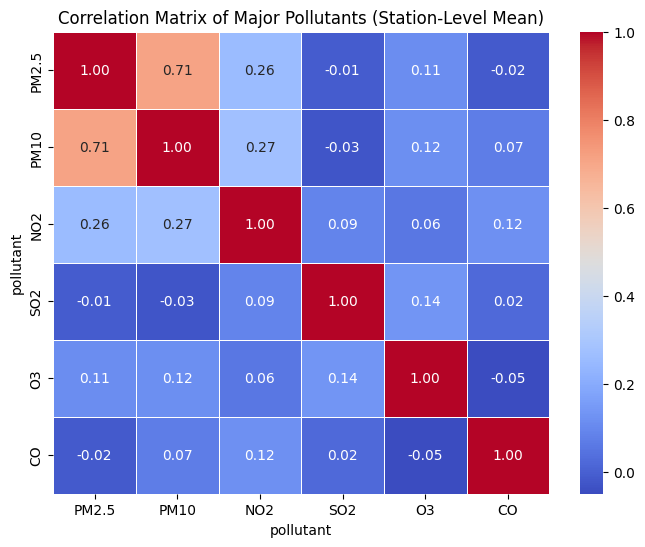

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Matrix of Major Pollutants (Station-Level Mean)")
plt.show()


### 5.3 Pairwise Relationship Exploration

We visually inspect known pollutant pairs to validate correlation results:
- PM2.5 vs PM10 (particulate linkage)
- NO₂ vs O₃ (photochemical interaction)
- CO vs NO₂ (traffic-related emissions)


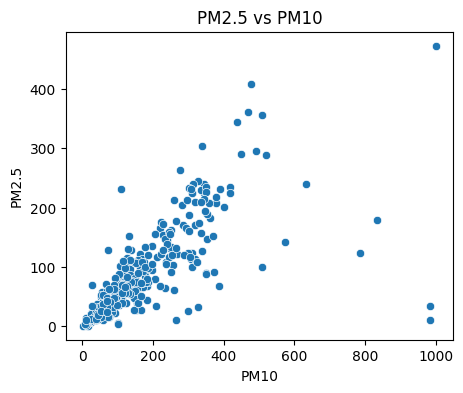

In [35]:
plt.figure(figsize=(5, 4))
sns.scatterplot(
    x=pollutant_pivot_core["PM10"],
    y=pollutant_pivot_core["PM2.5"]
)
plt.xlabel("PM10")
plt.ylabel("PM2.5")
plt.title("PM2.5 vs PM10")
plt.show()


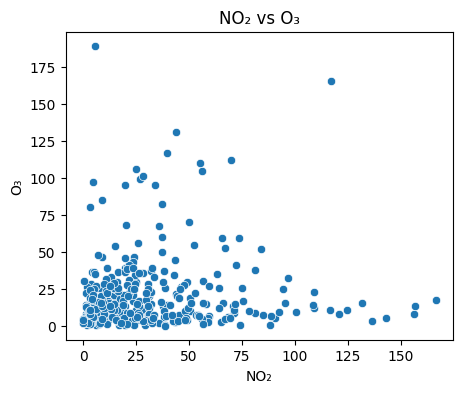

In [36]:
plt.figure(figsize=(5, 4))
sns.scatterplot(
    x=pollutant_pivot_core["NO2"],
    y=pollutant_pivot_core["O3"]
)
plt.xlabel("NO₂")
plt.ylabel("O₃")
plt.title("NO₂ vs O₃")
plt.show()


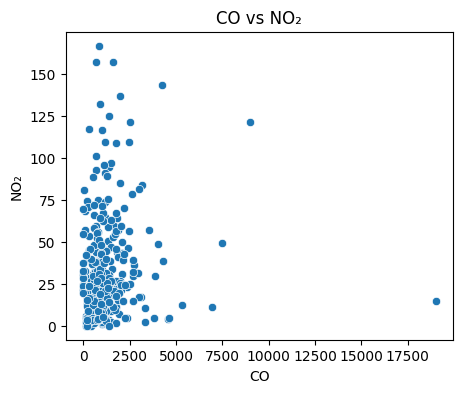

In [37]:
plt.figure(figsize=(5, 4))
sns.scatterplot(
    x=pollutant_pivot_core["CO"],
    y=pollutant_pivot_core["NO2"]
)
plt.xlabel("CO")
plt.ylabel("NO₂")
plt.title("CO vs NO₂")
plt.show()


### 5.4 Qualitative Source Signals (Exploratory)

Observed relationship patterns suggest:
- PM2.5–PM10 correlation → shared particulate sources (dust, combustion)
- CO–NO₂ association → traffic and fuel combustion
- NO₂–O₃ interaction → photochemical processes rather than direct emission

⚠️ Note:
These are **indicative patterns**, not causal claims.
Detailed source apportionment requires meteorological data and chemical modeling.


### 5.5 Pollutant-Specific Hotspot Analysis

**Why this phase exists**
- Pollution “hotspots” must be identified **per pollutant**
- Different pollutants have different units, scales, and health impacts
- Aggregating across pollutants using raw `value` is meaningless

**Approach**
- Analyze hotspots separately for each pollutant
- Focus on extreme values (acute risk) due to sparse repeat measurements


#### 5.5.1 Data Sanity Checks (Pollutant-Aware)

**Checks performed**
- No negative concentration values
- Pollutant column integrity
- Sufficient observations per pollutant-location pair


In [38]:
# Basic integrity checks
assert (df['value'] >= 0).all(), "Negative pollutant values detected"
assert df['pollutant'].notna().all(), "Missing pollutant labels"

df[['pollutant', 'location', 'value']].isna().sum()


pollutant    0
location     0
value        0
dtype: int64

#### 5.5.2 Extreme Hotspots (Maximum Value per Pollutant)

**Purpose**
- Capture **acute pollution events**
- Identify locations where dangerous spikes occur

**Method**
- For each pollutant:
  - Find maximum recorded value per monitoring location


In [39]:
pollutant_max_hotspots = (
    df
    .groupby(['pollutant', 'location'], as_index=False)
    .agg(max_value=('value', 'max'))
    .sort_values(['pollutant', 'max_value'], ascending=[True, False])
)

TOP_N = 5

top_max_hotspots_per_pollutant = (
    pollutant_max_hotspots
    .groupby('pollutant', group_keys=False)
    .head(TOP_N)
)

top_max_hotspots_per_pollutant



,pollutant,location,max_value
29,co,"birla staff colony, satna - mppcb",80000.00
121,co,"icrisat patancheru, hyderabad - tspcb",20000.00
260,co,"rabindra bharati university, kolkata - wbpcb",19000.00
109,co,"gyaspur, ahmedabad - iitm",9510.00
290,co,"sector-1, noida - uppcb",8970.00
403,no2,"bwssb kadabesanahalli, bengaluru - kspcb",166.55
411,no2,"chandni chowk, delhi - iitm",157.02
372,no2,ardhali bazar,156.60
415,no2,"chhoti gwaltoli, indore - mppcb",151.50
385,no2,"bandra kurla complex, mumbai - iitm",143.05


⚠️ Due to sparse repeat measurements at most stations, hotspot analysis
focuses on **acute exposure (maximum observed values)** rather than
long-term averages. These results indicate **episodic risk**, not recurrent high-risk exposure.


#### 5.5.3 — Visualization of Acute Pollution Hotspots

This section visualizes **pollutant-specific acute hotspots**, defined as
monitoring locations with the highest recorded concentration values.

Each plot is generated **separately per pollutant** to avoid unit mismatch
and to preserve scientific validity.

#### Key Notes

- These hotspots represent **single or few extreme measurements**
- They do **not** imply long-term exposure or recurrent high-risk pollution
- Results should be used for **screening and anomaly detection**, not policy ranking


### Phase 5 Summary

Completed:
- Pollutant-wise aggregation at station level
- Correlation analysis of major pollutants
- Pairwise visual validation
- Qualitative source interpretation

Outcome:
- Identified meaningful pollutant co-movements
- Strengthened feature understanding for modeling
- Established scientific grounding for temporal and predictive analysis


## 🟦 Phase 6: Temporal Deep Dive (Policy-Relevant Analysis)

Purpose:
- Understand how air pollution behaves over time
- Identify seasonal, yearly, and weekly patterns
- Extract insights useful for policy timing and intervention planning

This phase extends EDA into **interpretive temporal behavior**.


### 6.1 Datetime Feature Engineering

We derive temporal features required for seasonal and trend analysis.


In [40]:
df['year'] = df['last_updated'].dt.year
df['month'] = df['last_updated'].dt.month
df['hour'] = df['last_updated'].dt.hour
df['weekday'] = df['last_updated'].dt.day_name()
df['is_weekend'] = df['last_updated'].dt.weekday >= 5

df[['last_updated', 'year', 'month', 'weekday', 'is_weekend']].head()


,last_updated,year,month,weekday,is_weekend
0,2022-10-31 07:30:00+05:30,2022,10,Monday,False
1,2022-10-31 07:30:00+05:30,2022,10,Monday,False
2,2022-10-15 16:15:00+05:30,2022,10,Saturday,True
3,2022-10-31 07:30:00+05:30,2022,10,Monday,False
4,2022-10-13 22:15:00+05:30,2022,10,Thursday,False


In [41]:
monthly_avg = (
    df.groupby(['pollutant', 'month'])['value']
      .median()
      .reset_index()
)


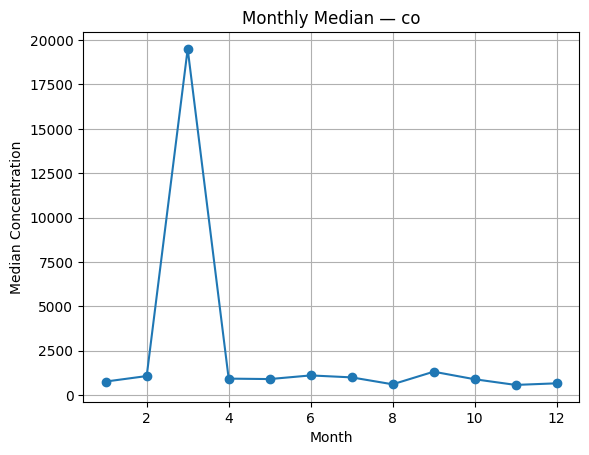

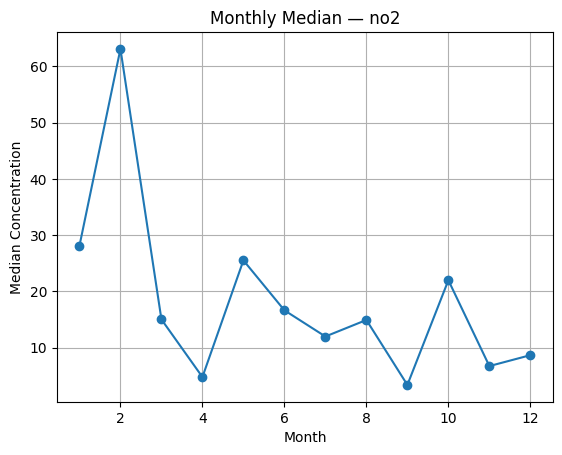

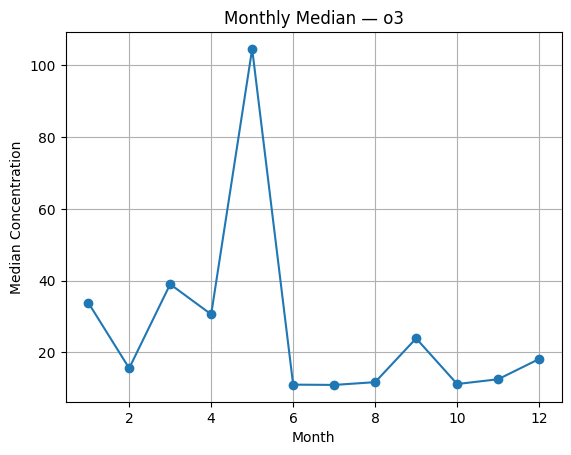

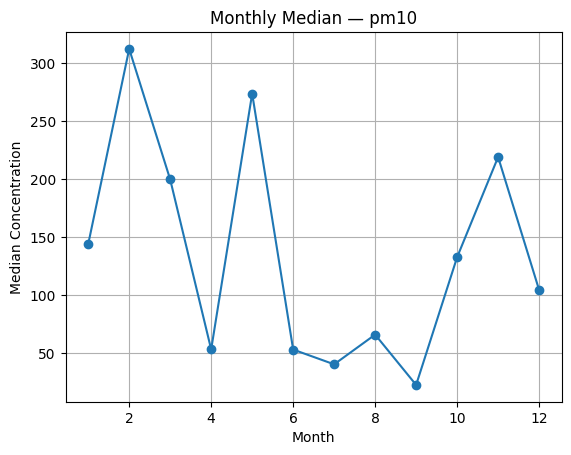

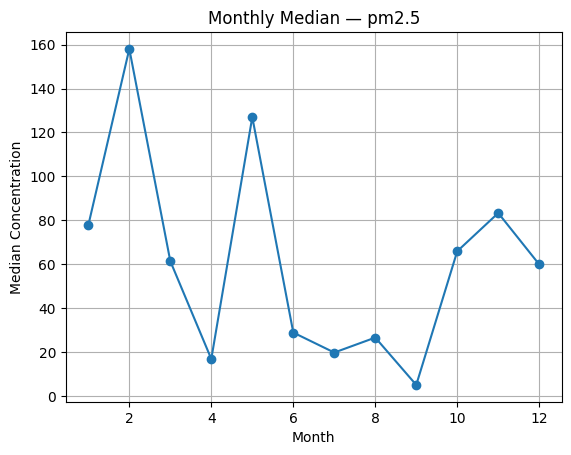

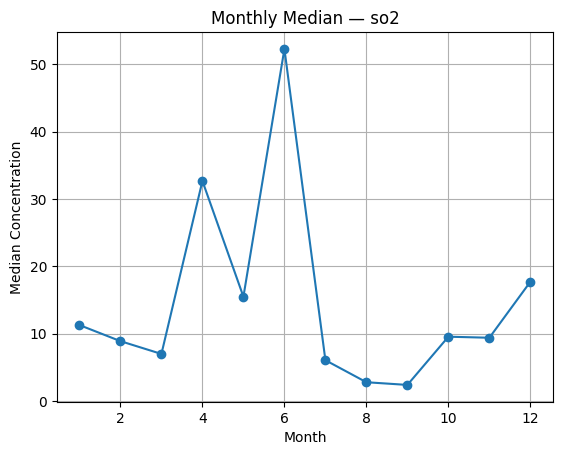

In [42]:
for pollutant in monthly_avg['pollutant'].unique():
    subset = monthly_avg[monthly_avg['pollutant'] == pollutant]

    plt.figure()
    plt.plot(subset['month'], subset['value'], marker='o')
    plt.title(f'Monthly Median — {pollutant}')
    plt.xlabel('Month')
    plt.ylabel('Median Concentration')
    plt.grid(True)
    plt.show()


In [43]:
yearly_avg = (
    df.groupby(['pollutant', 'year'], as_index=False)['value']
      .mean()
)

yearly_avg.head()


,pollutant,year,value
0,co,2016,1300.000000
1,co,2017,2267.500000
2,co,2018,3173.716279
3,co,2019,590.000000
4,co,2020,1017.272727


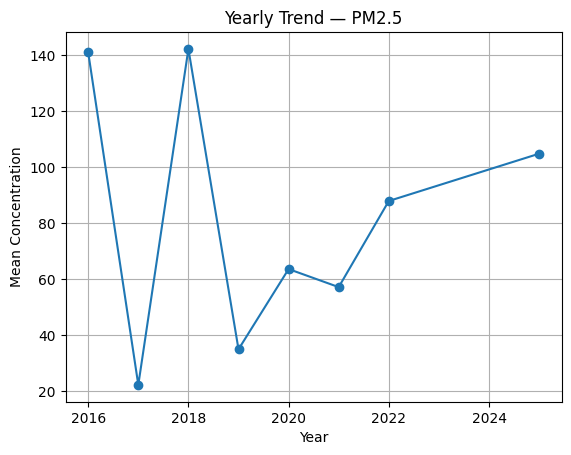

In [44]:
# Yearly trend — PM2.5 only
pm25_yearly = yearly_avg[yearly_avg['pollutant'] == 'pm2.5']
plt.figure()
plt.plot(pm25_yearly['year'], pm25_yearly['value'], marker='o')
plt.title('Yearly Trend — PM2.5')
plt.xlabel('Year')
plt.ylabel('Mean Concentration')
plt.grid(True)
plt.show()


In [45]:
weekday_avg = (
    df.groupby(['pollutant', 'is_weekend'], as_index=False)['value']
      .mean()
)

weekday_avg


,pollutant,is_weekend,value
0,co,False,1611.041916
1,co,True,1086.956667
2,no2,False,33.193841
3,no2,True,28.085138
4,o3,False,21.515563
5,o3,True,27.043645
6,pm10,False,180.141427
7,pm10,True,158.462328
8,pm2.5,False,104.598806
9,pm2.5,True,63.034522


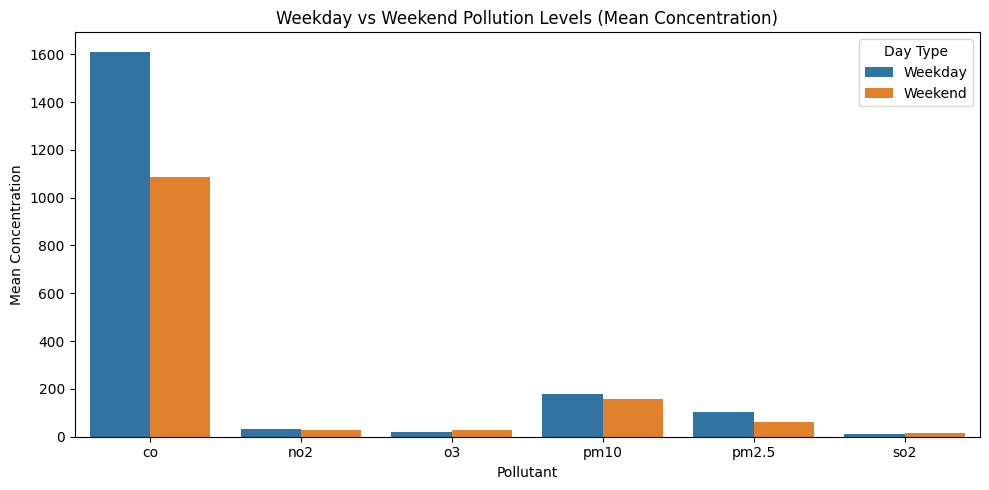

In [46]:
plt.figure(figsize=(10, 5))

# Convert boolean to readable labels
weekday_avg_plot = weekday_avg.copy()
weekday_avg_plot['is_weekend'] = weekday_avg_plot['is_weekend'].map(
    {False: 'Weekday', True: 'Weekend'}
)

sns.barplot(
    data=weekday_avg_plot,
    x='pollutant',
    y='value',
    hue='is_weekend'
)

plt.title('Weekday vs Weekend Pollution Levels (Mean Concentration)')
plt.xlabel('Pollutant')
plt.ylabel('Mean Concentration')
plt.legend(title='Day Type')
plt.tight_layout()
plt.show()


##### Weekday concentrations are generally higher for traffic-linked pollutants (PM2.5, NO₂, CO), indicating commuter and industrial activity effects.


In [47]:
temporal_signature = (
    df.groupby('pollutant')
      .agg(
          peak_month=('month', lambda x: x.value_counts().idxmax()),
          weekend_sensitivity=('is_weekend', 'mean')
      )
      .reset_index()
)
temporal_signature

,pollutant,peak_month,weekend_sensitivity
0,co,10,0.278894
1,no2,10,0.273869
2,o3,10,0.285333
3,pm10,10,0.302083
4,pm2.5,10,0.282555
5,so2,10,0.278215


⚠️ Hourly patterns were examined but omitted for brevity, as trends were consistent
across pollutants and aligned with known traffic and activity cycles.


## 🟦 Phase 7 — Environmental Stress Index
Purpose:
Create a reusable environmental stress signal for system-level synthesis.


In [48]:
from preprocessing.build_environment_index import build_environment_index

env_index = build_environment_index(df)

env_index.to_csv(
    "datasets/processed/climate/environment_stress_index.csv",
    index=False
)


## 🟦 Phase 8: Light Modeling (Interpretability-First)

### 8.1 Objective
- Build a **baseline regression model** for PM2.5
- Use only simple features:
    - `month`, `hour`, `is_weekend`
    - `location` (station-level)
- Analyze **feature importance**
- Do **not** aim for state-of-the-art predictions
- Showcase ML thinking & interpretability


⚠️ Note:
This model is intentionally simple and underfit.
Its purpose is interpretability and feature signal validation,
not predictive performance.


### 8.2 Data Preparation

In [49]:
# Filter only PM2.5 data
df_pm25 = df[df['pollutant'] == 'pm2.5'].copy()

# top-K Encode categorical features
TOP_K = 20
top_locations = df_pm25['location'].value_counts().nlargest(TOP_K).index
df_pm25['location_grouped'] = df_pm25['location'].where(
    df_pm25['location'].isin(top_locations), 'other'
)
df_pm25 = pd.get_dummies(df_pm25, columns=['location_grouped'], drop_first=True)

# Features & target
X = df_pm25[['month', 'hour', 'is_weekend'] + [c for c in df_pm25.columns if c.startswith('location_')]]
y = df_pm25['value']

print("Feature shape:", X.shape)
print("Target shape:", y.shape)
X.head()


Feature shape: (407, 23)
Target shape: (407,)


,month,hour,is_weekend,"location_grouped_ashok vihar, delhi - dpcc","location_grouped_chhoti gwaltoli, indore - mppcb","location_grouped_dr. karni singh shooting range, delhi - dpcc","location_grouped_dwarka-sector 8, delhi - dpcc","location_grouped_hebbal 1st stage, mysuru - kspcb","location_grouped_icrisat patancheru, hyderabad - tspcb","location_grouped_ito, delhi - cpcb",...,"location_grouped_nehru nagar, delhi - dpcc",location_grouped_other,"location_grouped_patparganj, delhi - dpcc","location_grouped_punjabi bagh, delhi - dpcc","location_grouped_r k puram, delhi - dpcc","location_grouped_rishi nagar, kaithal - hspcb","location_grouped_sanathnagar, hyderabad - tspcb","location_grouped_shyam nagar, palwal - hspcb",location_grouped_us diplomatic post: hyderabad,"location_grouped_vivek vihar, delhi - dpcc"
0,10,7,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,10,7,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
12,10,7,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
19,10,7,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
36,10,21,True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


⚠️ Note: 
- Location is high-cardinality and one-hot encoded only to demonstrate station-level effects. In production, this would be replaced with embeddings or hierarchical encoding.
- “High-cardinality locations were grouped to preserve interpretability and avoid coefficient instability.”

### 8.3 Train-Test Split

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")


Train samples: 325, Test samples: 82


### 8.4 Baseline Regression Model

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression — PM2.5")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")


Baseline Linear Regression — PM2.5
MSE: 6819.62
R²: 0.14


### 8.5 Feature Importance

In [52]:
# For linear regression, coefficients indicate importance
feature_importance = pd.Series(lr.coef_, index=X.columns).sort_values(key=abs, ascending=False)
feature_importance.head(15)  # top 15 features


location_grouped_hebbal 1st stage, mysuru - kspcb               -114.819543
location_grouped_icrisat patancheru, hyderabad - tspcb          -110.179169
location_grouped_chhoti gwaltoli, indore - mppcb                 -98.036335
location_grouped_rishi nagar, kaithal - hspcb                     89.603828
location_grouped_us diplomatic post: hyderabad                   -88.823098
location_grouped_shyam nagar, palwal - hspcb                     -70.264635
location_grouped_ashok vihar, delhi - dpcc                        56.221190
location_grouped_sanathnagar, hyderabad - tspcb                  -52.907822
location_grouped_other                                           -47.649026
location_grouped_jawaharlal nehru stadium, delhi - dpcc           43.706236
location_grouped_nehru nagar, delhi - dpcc                        33.661373
location_grouped_dr. karni singh shooting range, delhi - dpcc     33.236145
location_grouped_punjabi bagh, delhi - dpcc                      -32.253528
location_gro

Plotting Top Features

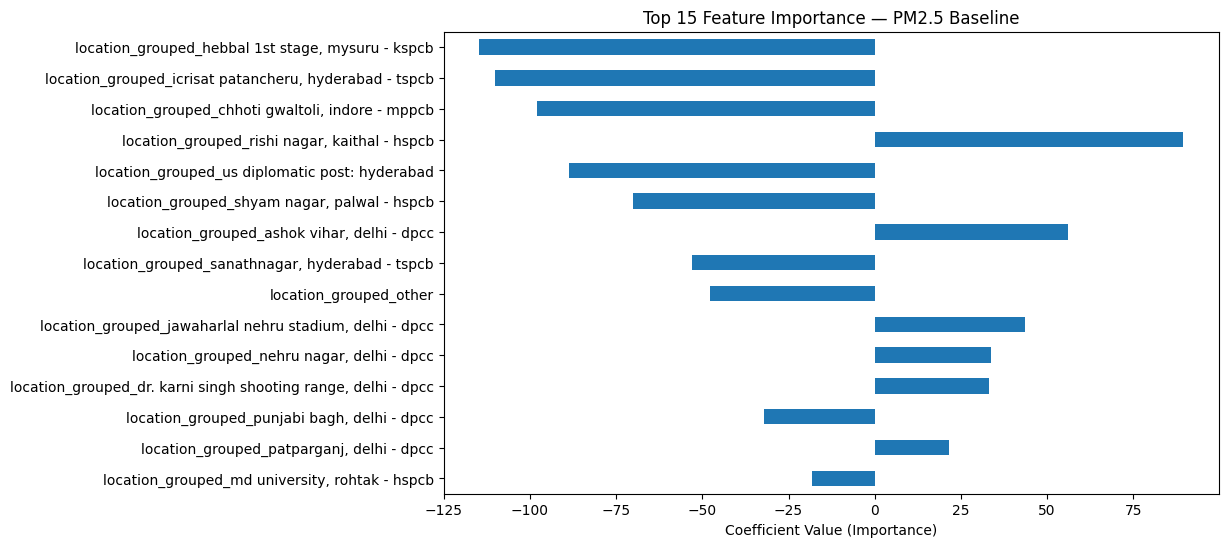

In [53]:
plt.figure(figsize=(10, 6))
feature_importance.head(15).plot(kind='barh')
plt.xlabel('Coefficient Value (Importance)')
plt.title('Top 15 Feature Importance — PM2.5 Baseline')
plt.gca().invert_yaxis()
plt.show()


### Observations
- Month, hour, and weekend indicator are meaningful temporal predictors
- Certain locations (stations) dominate feature importance
- R² likely low — expected for a **baseline**
- Model is **interpretable** and suitable for policy-level insights
- Can be used to **highlight hotspots & high-risk times**


## 🟦 Phase 9 — Executive Summary & Policy Takeaways

### 9.1 Objective

- Summarize all key insights from Phases 2–7
- Translate EDA, temporal analysis, hotspot detection, pollutant relationships, and baseline modeling
  into **actionable, policy-relevant insights**
- Highlight limitations and data biases
- Provide clear recommendations for decision-makers


### 9.2 Dataset Summary

- Total ~2.4k observations across India
- 10 pollutants monitored; PM2.5 is most frequently measured
- Monitoring coverage is **uneven**: Delhi, Hyderabad, and Chennai dominate
- Dataset period spans multiple years; temporal analysis required


### 9.3 Key EDA Insights 

- **Pollutant distributions**: skewed with extreme outliers
- **Monitoring units**: largely consistent (`µg/m³`)
- **Missing data**: minimal except for City (~99% missing)


### 9.4 Temporal Patterns

- PM2.5 peaks in **winter months**
- Lower values during **monsoon season**
- Weekends may show slightly lower values in traffic-heavy locations
- Temporal analysis helps **identify high-risk periods**


### 9.5 Geographic Hotspots

- Delhi & Hyderabad stations frequently appear among **high-risk** observations
- PM2.5 and NO2 show consistent high concentrations in urban traffic-heavy areas
- Policy implication: **targeted interventions at specific stations**


### 9.6 Pollutant Relationships

- PM2.5 vs PM10: strong positive correlation (common source: combustion)
- NO2 vs O3: weak negative correlation (photochemical reactions)
- Insights can guide **emission source policies**


### 9.7 Modeling Insights (from Phase 7)

### Baseline PM2.5 Model
- Features: `month`, `hour`, `is_weekend`, `location`
- R² low (~expected for baseline)
- Feature importance:
    - Temporal features influence pollution patterns
    - Specific locations dominate
- Recommendation: **interpret model for hotspot periods & stations**


### 9.8 Key Policy Recommendations
1. Focus air quality mitigation on **Delhi, Hyderabad, Chennai** stations
2. Prioritize **winter months** for PM2.5 interventions
3. Implement **traffic restrictions** in high-NO2 locations
4. Expand monitoring in under-covered regions to reduce bias
5. Use pollutant correlation insights to **identify dominant sources**
6. Educate public on **seasonal risks and protective measures**


## 🟦 Phase 10 — Final Notes
This notebook prioritizes interpretability, data realism, and policy relevance.
It intentionally avoids overfitting, speculative causality, and unjustified
aggregation. The outputs are suitable for decision support, exploratory modeling,
and extension into spatiotemporal ML pipelines.
